In [1]:
%matplotlib inline


# More complex scenarios 

The preceding chapter introduced four different ways of preparing a solution and the forms the backbone of running simulations on World Bank models in `modelflow`. This chapter builds on those examples and delves into some of the challenges involved in translating a real-world policy challenge into the model-world and then back again.


The particular problem to be examined is in the introduction of a Carbon Tax. The model used and the example presented are both taken from the model of Pakistan presented here: {cite:author}`burns_climate_2021`.

## Setting up the environment

As always the modelflow and other python libraries that are to be used must be imported into the current session. 

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

In [3]:
from modelclass import model 
model.widescreen()
model.scroll_off()
%load_ext autoreload
%autoreload 2

## Load a pre-existing model, data and descriptions 

Load the Pakistan model, which is comprised of the model object, its estimated equations and the data.  The `pcim` file was created by the World Bank from the original EViews model used in the paper {cite:author}`burns_climate_2021`.  



In [4]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep="Baseline")

file read:  C:\mflow\Aug23\papers\mfbook\content\models\pak.pcim


```{index} single: Carbon tax example(s)
```
```{index} single: More complex scenarios  - carbon tax
```


## The policy problem

The objective of this chapter is to produce a simulation of the economic and climate effects of the introduction of a carbon tax in Pakistan.

The variable ```mpak``` loaded above contains the model instance, the variables, equations and the data for the model.  On load the model was solved, and the results of that initial solve was assigned to the `DataFrame` ```baseline```. 

The Pakistan model contains three carbon tax variables: 

|Mnemonic | Meaning |
|:--|:--|
|PAKGGREVCO2CER|The effective carbon tax rate on Coal|
|PAKGGREVCO2GER|The effective carbon tax rate on Gas|
|PAKGGREVCO2OER|The effective carbon tax rate on Crude Oil|

As discussed in earlier chapters the meaning of the mnemonics can be retrieved from the model:

In [5]:
mpak['PAKGGREVCO2*ER'].des
    

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


```{index} single: Model object; Wildcard search on variable descriptions the ! operator
```
```{index} single: Wildcard searches| The ! operator: search on variable descriptions 
```


Alternatively, one can search on the variable descriptions to retrieve the mnemonics of variables. Below, the exclamation mark (!) at the beginning of the string notifies the matching algorithm to search the variables' descriptions (not the mnemonics) and return all variables that match.


In [6]:
mpak['!*Carbon*'].des

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


```{index} single: Modelflow; Dataframe - variable descriptions
```
```{index} single: DataFrame; Variable descriptions - set or change
```


## Add variable descriptions
A modelflow model imported from EViews will inherit the variable descriptors coming from Eviews.  Not all EViews variables will necessarily have a description so such descriptions can be added to the existing using the `.set_var_descri[tion()` method as below.

As coded, the call

`mpak.set_var_description({**mpak.var_description,**extra_description})`

adds the extra_description dictionary to the pre-existing mpak,var_description dictionary.

Several `modelflow` methods include a `rename` option, which if set to True will substitute the description for the variable name in any outputs.  Variables can also be selected for by using the `mpak['!*subtext*']` syntax, where subtext is some text that appears in the variable descriptor.



In [7]:
extra_description = {'PAKNYGDPMKTPKN': 'GDP',
'EMISCOAL'        : 'Coal emissions',
'EMISGAS'         : 'Gas Emissions',
'EMISOIL'         : 'Gas Emissions',
'PAKCCEMISCO2CKN' : 'Coal emissions, tCO2e',
'PAKCCEMISCO2GKN' : 'Natural Gas emissions, tCO2e',
'PAKCCEMISCO2OKN' : 'Crude Oil emissions, tCO2e',
'PAKCCEMISCO2TKN' : 'Total emissions, tCO2e',
'PAKGGREVEMISCN'  : 'Revenue from emissions taxes',
 'PAKLMUNRTOTLCN': 'Unemployment rate',
 'PAKGGDBTTOTLCN_': 'Debt (%GDP)',
 'PAKGGREVTOTLCN': 'Fiscal revenues',
 'PAKWDL': 'Working days lost due to pollution'}
mpak.set_var_description({**mpak.var_description,**extra_description})

## Simulating the impact of imposing a carbon price

To run a simulation, the following steps must invariably be followed.

1. Create a new DataFrame, typically a copy of an existing one.
2. Change the value  in the new df of the variable(s) to be shocked.
3. Solve the model using the newly altered df as the input df.



In [8]:
# Create copy of the baseline df
alternative_df = baseline.copy()
#set the effective carbon tax of all three carbon tax variables equal to 30 USD
alternative_df.loc[2025:2100,['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']] = 30 


The above used the `pandas` function `.loc[]` to change the Carbon Tax rate variables.

The `modelflow` method `.upd()` could be used to perform the same change. 

```{index} single: Scenario set up;  use .upd() to initialize shock dataframe
```
```{index} single: Modelflow; .upd() used to initialize shock dataframe
```

In [9]:
# This modelflow command is equivalent to the previous standard pandas command abive that used the .loc[] syntax
CT30df  =  baseline.upd("<2025 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")

```{index} single: Simulation; Solve the model
```
```{index} single: Solve the model 
```
```{index} single: Scenarios; Solve the model
```

### Solve the model

Solving the model is as simple as calling the mpak function with the altered `DataFrame` and assigning the results to dataframe (`resultsdf` in this instance).  The `keep` option causes a copy of the dataframe to be stores within the mpak model object.

In [10]:
resultsdf = mpak(CT30df,2020,2100,keep="Nominal $30USD Carbon tax") # simulates the model 

#### Examining the results

Every time the model is solved the results of the simulation are assigned to a variable on the left hands side of the solve call (`resultdf` in the example above.  The results of the most recent scenario are also always stored in the `.lastdf` `DataFrame` that is part of the properties of any `modelflow` model. the `basedf` property of `mpak` (an instantiation of a modelflow model object) contains a copy of the initial DataFrame from which the model was built.

The `DataFrames` `baseline` and `resultsdf` were created when the model was solved the model (initially on load) and now with the simulation.  Currently their contents are the same as, but separate from, the contents of `basedf` and `lastdf`.

:::{note}

The standard dataframes are part of the `modelflow` object and managed by it.

- **mpak.basedf**: Dataframe with the values for baseline
- **mpak.lastdf**: Dataframe with the values from the most recent simulation
:::



The impact of the imposition of the carbon tax in the model is relatively quick, resulting in an overall decline in emissions of 22.2% in the first year, with coal emissions recording the biggest hit at -41.2 percent.


```{index} single: with clause; .set_smpl(begin,end) method to temporarily alter the active rows in the the model object
```
```{index} single: ModelFlow; .set_smpl(begin,end) method
```


In [11]:
with mpak.set_smpl(2023,2030):
    print(round(mpak['PAKCCEMISCO2*'].difpctlevel.mul100.df,2));

      PAKCCEMISCO2CKN  PAKCCEMISCO2GKN  PAKCCEMISCO2OKN  PAKCCEMISCO2TKN
2023             0.00             0.00             0.00             0.00
2024             0.00             0.00             0.00             0.00
2025           -41.19           -26.99           -10.93           -22.17
2026           -40.06           -25.72           -10.98           -21.56
2027           -38.85           -24.48           -10.89           -20.89
2028           -37.59           -23.30           -10.68           -20.17
2029           -36.26           -22.14           -10.35           -19.38
2030           -34.89           -21.01            -9.95           -18.55


```{index} single: Report-writing; difpctlevel 
```
```{index} single: Scenario results; difpctlevel 
```

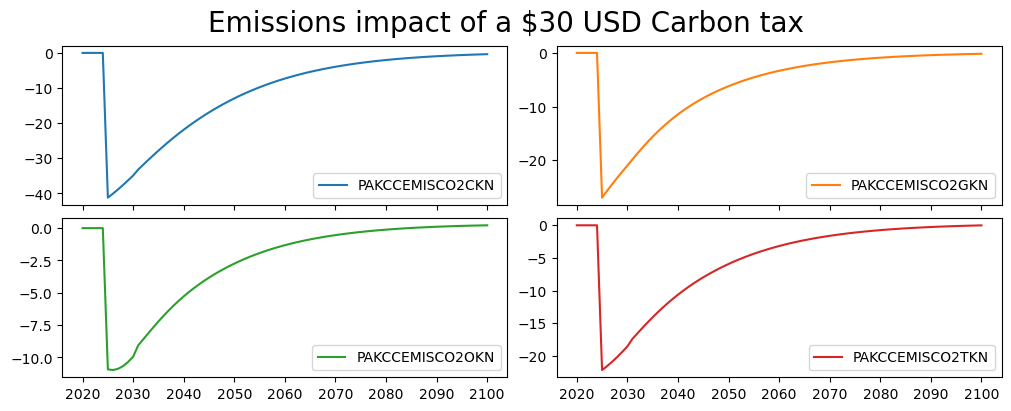

In [12]:
mpak['PAKCCEMISCO2?KN'].difpctlevel.mul100.plot(title="Emissions impact of a $30 USD Carbon tax",showfig=True)


Abstracting from the fact that the impact is occurring too quickly (it would take time for the substitution towards alternative sources of power to occur), the fact that impacts are fading with time suggests an error in the specification of the shock.  High domestic inflation means that the relative price change of a given Carbon price is declining over time.

## Re-thinking the shock as an ex-ante real shock

Inflation in Pakistan is relatively high so a $30 shock quickly loses its relative price effect. Increasing the nominal value of the Carbon Tax by the amount of domestic inflation (converted into USD each year) would resolve the problem. 

Below a new dataframe is created as a copy of the baseline and the three Carbon taxes are first set to $30 in 2025 and then grown at the rate of domestic inflation to keep the relative price of the Carbon Tax constant.

Finally the model is re-solved.

```{index} single: Scenarios;  use .mfcalc() to initialize shocked dataframe
```
```{index} single: Simulations;  use .mfcalc() to initialize shocked dataframe
```
```{index} mfcalc() to initialize shocked dataframe
```

In [13]:

import modelmf  # import the mfcalc functionality and append it to standard pandas
CT30realdf  =  baseline.copy()
CT30realdf=CT30realdf.upd("<2025 2025> PAKGGREVCO2CER PAKGGREVCO2OER PAKGGREVCO2GER = 30")

#NB: Variables used 
#   PAKNECONPRVTXN is the consumer price deflator
#   PAKPANUSATLS id the USD exchange rate
CT30realdf=CT30realdf.mfcalc('''
                              <2026 2100> PAKGGREVCO2CER = PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                                      PAKGGREVCO2OER = PAKGGREVCO2OER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                                      PAKGGREVCO2GER = PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1))
                          ''')                         

CT30realdf.loc[2023:2030,'PAKGGREVCO2CER']


resultsdf = mpak(CT30realdf,2020,2100,keep="Real $30USD Carbon tax") # simulates the model 


In [14]:
with mpak.set_smpl(2023,2030):
    print(mpak['PAKGG*ER'].df)

      PAKGGREVCO2CER  PAKGGREVCO2GER  PAKGGREVCO2OER
2023       -5.549839      -41.000884       -8.710650
2024       -5.549839      -41.000884       -8.710650
2025       30.000000       30.000000       30.000000
2026       31.827691       31.827691       31.827691
2027       33.642459       33.642459       33.642459
2028       35.451255       35.451255       35.451255
2029       37.263353       37.263353       37.263353
2030       39.091481       39.091481       39.091481


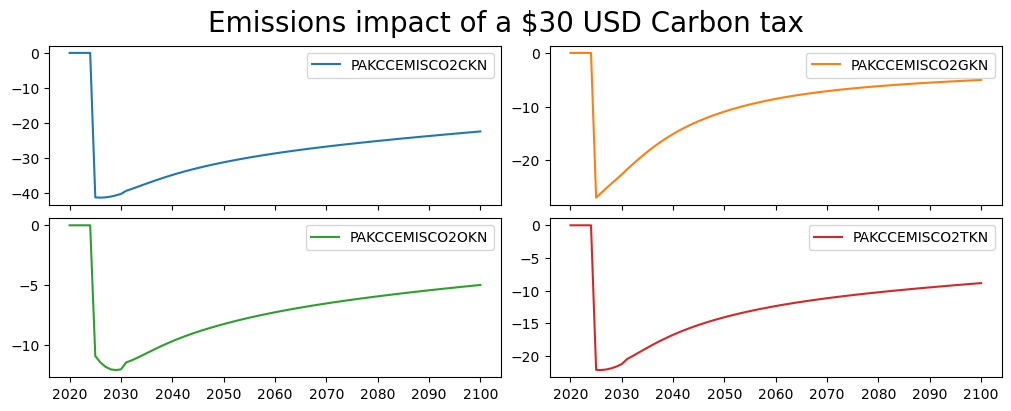

In [15]:

mpak['PAKCCEMISCO2?KN'].difpctlevel.mul100.plot(title="Emissions impact of a $30 USD Carbon tax",showfig=True)


These results are better, but still there is an erosion of the effect of the tax.


On introspection, this is likely due to the fact that the carbon tax itself is inflationary.  As a result, prices probably rose to a higher level than supposed by the ex ante calculation.

To deal with this, a different approach is needed.  Rather than maintaining the carbon price as an exogenous variable, instead it should be made an endogenous variable by changing the model and adding equations for all of the carbon tax variables.

Before doing so lets save the current version of the model for further work later.

In [16]:
mpak.modeldump('..\models\pakCarbonTaxScenarios.pcim')

```{index} single: Carbon tax simulation; Complex changing equations
```
```{index} single: Simulations; changing equations
```
```{index} single: Scenarios; changing equations
```
```{index} single: Revising model equations
```

## Changing the model -- modifying and or adding equations

To endogenize the carbon price, an equation for each carbon price has to be added to the model.   This cane be done with the `.equpdate()` method.  

In [17]:
#Reload original model and data
mpak1,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1,keep="Baseline")
#Create a new model object mpakreal and new baseline dataframe-- baselinereal 
#The nominal carbon taxes (expressed in USD) are now endogenous 
# and increase with domestic inflation and the exchange rate

mpakreal,baselinereal = mpak1.equpdate('''
<fixable> PAKGGREVCO2CER = PAKGGREVCO2CER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
<fixable> PAKGGREVCO2OER = PAKGGREVCO2OER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
<fixable> PAKGGREVCO2GER = PAKGGREVCO2GER(-1) * (PAKNYGDPMKTPXN*PAKPANUSATLS) / (PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1))
''',add_add_factor=False, calc_add=False,newname='Pak model, with real Carbon price equations')


file read:  C:\mflow\Aug23\papers\mfbook\content\models\pak.pcim

The model:"PAK" got new equations, new model name is:"Pak model, with real Carbon price equations"
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = (PAKGGREVCO2CER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2OER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2OER = (PAKGGREVCO2OER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2OER_D)+ PAKGGREVCO2OER_X*PAKGGREVCO2OER_D$
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2GER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2GER = (PAKGGREVCO2GER(-1)*(PAKNYGDPMKTPXN*PAKPANUSATLS)/(PAKNYGDPMKTPXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREV

```{index} single: ModelFlow; .equupdate() - revising model equations 
```
```{index} single: Revising model equations; .equupdate() 
```
```{index} single: Model equations; Revise equations with .equupdate() 
```


As written, the `.equpdate()` command creates a new model, which is a copy of the existing model with three new equations.

Each equation grows the nominal rate of the carbon tax at the same rate as *ex ante* inflation (`PAKNECONPRVTXN`) converted into USD via the exchange rate `PAKPANUSATLS`. The equations are introduced as exogenizable equations (as distinct from an identity which must always hold) by adding the \<fixable\> prefix to each equation. The equations are not estimated, so no add-factors are included in the equations.

The output for the `.equpdate()` reports the actual formulae included in the model. 
```
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = (PAKGGREVCO2CER(-1)*(PAKNECONPRVTXN*PAKPANUSATLS)/(PAKNECONPRVTXN(-1)*PAKPANUSATLS(-1)))* (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D$
Adjust calc:No frml for adjustment calc 
```
Note that because the equations are to be fixable, an \_X and \_D variable are added to the specified equations. Combined they effectively split each equation into  two:
1. the specified equations when \_D equals zero
2. equal to \_X when the \_D equals one.

The newly created model is given the name mpakreal and is given a text description.

Following the addition of the equations, the new variables (\_D and \_X) must be initialized. The \_X variables are made equal to the current values of the various tax rates, while the \_D is set to 1 everywhere -- effectively turning the equation off and re-creating the same situation as the initial model where the tax rates are fully exogenous.

In [18]:
#Exogenizes the newly added equations and sets the dummy =1 amd the _x to the current value of the dependent variable  
baseline_real=mpakreal.fix(baselinereal,'PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER')


The folowing variables are fixed
PAKGGREVCO2CER
PAKGGREVCO2GER
PAKGGREVCO2OER


The fix command above effectively does in one line all of the following code.
```
baseline_real=baselinereal.copy()

#Create the _X variables if we exogenize the equation
baseline_real = baseline_real.mfcalc('''
PAKGGREVCO2CER_X = PAKGGREVCO2CER
PAKGGREVCO2GER_X = PAKGGREVCO2GER
PAKGGREVCO2OER_X = PAKGGREVCO2OER
''')

#create the _D varibale so we can exogenize the equations (set _D=1)-- currently it is exogenized 
baseline_real = baseline_real.upd('''
<-0 -1> 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 1
''')
```

Finally the new model is solved, the result is kept in a new baseline and a quick check ensures that the model did indeed reproduce the data that it was originally fed, including the initial Carbon Tax levels.

In [19]:

#Solve the model for the new baseline
res = mpakreal(baseline_real,2021,2100,alfa=0.5,keep='Baseline - adjusted model') 

mpakreal['PAKNYGDPMKTPKN PAKNECONPRVTXN PAKGGBALOVRL PAKGGREVCO2CER PAKCCEMISCO2TKN'].difpctlevel.mul100.df

,PAKNYGDPMKTPKN,PAKNECONPRVTXN,PAKGGREVCO2CER,PAKCCEMISCO2TKN
2021,0.0,0.0,-0.0,0.0
2022,0.0,0.0,-0.0,0.0
2023,0.0,0.0,-0.0,0.0
2024,0.0,0.0,-0.0,0.0
2025,0.0,0.0,-0.0,0.0
...,...,...,...,...
2096,0.0,0.0,-0.0,0.0
2097,0.0,0.0,-0.0,0.0
2098,0.0,0.0,-0.0,0.0
2099,0.0,0.0,-0.0,0.0


### Solving the revised model

With the new model generated, it can now be solved with the real tax rate endogenized in the forecast period.  This involves three steps.

1. Set the nominal tax rate to 30 in 2025
2. Now Endogenize the equation for the rest of the period
3. Solve the model.


In [20]:
scenario_real_CTax = baseline_real.upd('''
<2025 2025> 
PAKGGREVCO2CER_x PAKGGREVCO2GER_x PAKGGREVCO2OER_x = 30 # Sets the exogenous value to 30 in 2025
<2026 2100 > 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_d = 0   # Endogenizes the new equations for the rest of time so that the real-rate stays at 30USD
''')


_ = mpakreal(scenario_real_CTax,2021,2100,alfa=0.5,keep='Real model real tax = 30 at 2025 prices and exchange  rates')





Initially the Carbon tax comes in at 30 but gradually its rate in USD rises in line with inflation such that it reaches $1500 by 2100.  

In [21]:

round(mpakreal['PAKGGREVCO2?ER PAKNECONPRVTXN PAKPANUSATLS'].df,1)

,PAKGGREVCO2CER,PAKGGREVCO2GER,PAKGGREVCO2OER,PAKNECONPRVTXN,PAKPANUSATLS
2021,-5.5,-41.0,-8.7,1.8,107.0
2022,-5.5,-41.0,-8.7,2.0,106.8
2023,-5.5,-41.0,-8.7,2.1,106.7
2024,-5.5,-41.0,-8.7,2.3,106.6
2025,30.0,30.0,30.0,2.5,106.2
...,...,...,...,...,...
2096,1098.5,1098.5,1098.5,106.6,94.3
2097,1158.3,1158.3,1158.3,112.7,94.1
2098,1221.4,1221.4,1221.4,119.1,93.9
2099,1288.0,1288.0,1288.0,125.9,93.7


This seemingly very high level is just a reflection of the 75 years of inflation that compounded require a much higher nominal Carbon tax rate to have the same relative price effect. The cumulative effect of inflation in the range of 5.5 real  per annum causes the price level to increase 74 times (7400 percent increase  133/1.8 from fourth data column in the above table).  

The table below shows the same data but in growth rate terms -- indicating that the Carbon tax effective rate is gradually rising each year in line domestic inflation adjusted for the exchange rate.

In [22]:
mpakreal['PAKGGREVCO2?ER PAKNECONPRVTXN PAKPANUSATLS'].pct.mul100.df

,PAKGGREVCO2CER,PAKGGREVCO2GER,PAKGGREVCO2OER,PAKNECONPRVTXN,PAKPANUSATLS
2021,0.000000,0.000000,0.000000,9.476828,-0.158806
2022,0.000000,0.000000,0.000000,8.776453,-0.155332
2023,0.000000,0.000000,0.000000,7.978008,-0.137261
2024,0.000000,0.000000,0.000000,7.263911,-0.119262
2025,-640.556268,-173.169155,-444.405991,9.314719,-0.301653
...,...,...,...,...,...
2096,5.448291,5.448291,5.448291,5.695556,-0.201709
2097,5.447813,5.447813,5.447813,5.695309,-0.201691
2098,5.447267,5.447267,5.447267,5.694990,-0.201668
2099,5.446663,5.446663,5.446663,5.694608,-0.201640


### Results

The results from the simulation with the Carbon Tax rate endogenized so as to maintain its real value over time, are broadly consistent with the results from the ex ante real scenario performed above.



In [23]:
mpakreal['PAKCCEMISCO2?KN'].difpctlevel.mul100.df

,PAKCCEMISCO2CKN,PAKCCEMISCO2GKN,PAKCCEMISCO2OKN,PAKCCEMISCO2TKN
2021,0.000000,0.000000,0.000000,0.000000
2022,0.000000,0.000000,0.000000,0.000000
2023,0.000000,0.000000,0.000000,0.000000
2024,0.000000,0.000000,0.000000,0.000000
2025,-41.186182,-26.992933,-10.929825,-22.167101
...,...,...,...,...
2096,-24.685906,-11.690040,-5.325702,-11.352754
2097,-24.542465,-11.608038,-5.276459,-11.273062
2098,-24.399563,-11.526500,-5.227608,-11.193826
2099,-24.257187,-11.445418,-5.179141,-11.115035


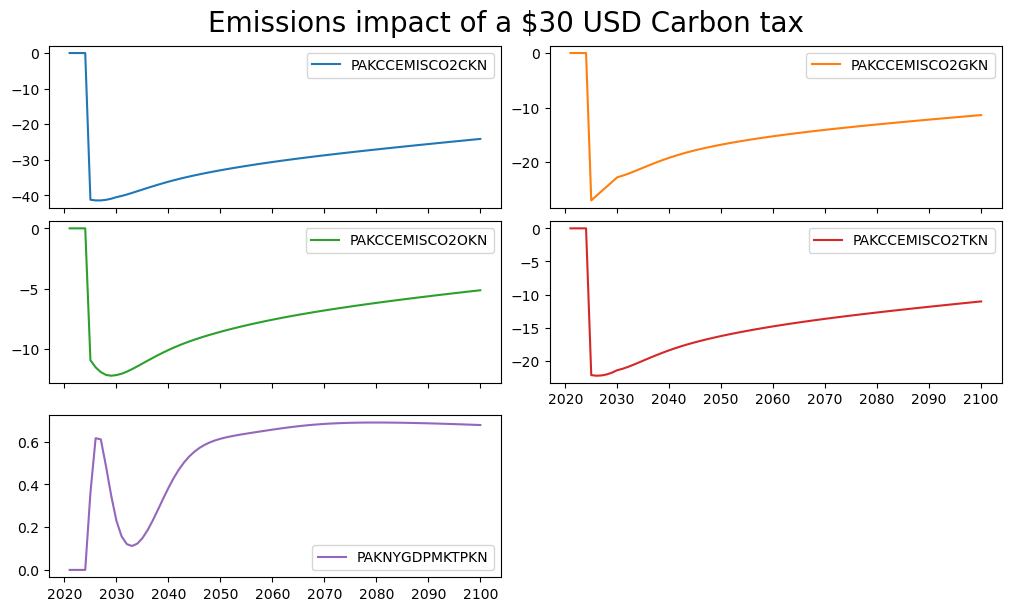

In [24]:
mpakreal['PAKCCEMISCO2?KN PAKNYGDPMKTPKN'].difpctlevel.mul100.plot(title="Emissions impact of a $30 USD Carbon tax",showfig=True)

The modified model, which preserves the real value of the carbon tax has a permanent and substantive negative effect on emissions. The impact is not at an unchanging level, reflecting in part adaptation within the economy. Of particular import is what is being done with the revenues from the Carbon tax. As the structure of GDP (shifts to less carbon intensive activities) carbon tax revenues fall even as the Carbon Tax rate rises. Note, the percent deviation of emissions tends to decrease over time in this scenario principally because the level of activity (GDP) is higher with the Carbon Tax than without it. As a result,  emissions are higher than they would have been had GDP remained unchanged. For the Pakistan model, the positive impact of the Carbon tax is mainly explained by co-benefits, notably reduced reliance on more distortive taxes such as payroll taxes and because of reductions in informality (see {cite:t}`burns_climate_2021` for more details how these effects operate in the Pakistan model).
